# **Rule of Thumb 2**: Use the Power Play Earlier





Are teams using the power play too late?  We saw from Rule of Thumb 1 that sacrificing for the PP probably isn’t worth the risk, but what about when the risks of holding on aren’t as obvious?  Our data says teams are absolutely waiting too long, at least for a specific subset of game states.

## **Imports and Load Data**

In [ ]:
# imports
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# load Ends.csv from github
ends_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Ends.csv'
stones_path = 'https://raw.githubusercontent.com/CSAS-Data-Challenge/2026/refs/heads/main/Stones.csv'

Ends = pd.read_csv(ends_path)
Stones = pd.read_csv(stones_path)

## **Data Transformations**

In [ ]:
## Get which team has the hammer

# getting data from games is a bitch, so I'm gonna be a clever bastard and get it from stones
team_hammer = Stones[Stones['ShotID'].isin([7,8])][['CompetitionID', 'SessionID', 'GameID', 'EndID', 'ShotID', 'TeamID']]
# get the team with the hammer - or without
team_hammer['ShotID'] = team_hammer['ShotID'] - 7
team_hammer.rename(columns={'ShotID': 'Hammer'}, inplace=True)

In [ ]:
## Merge onto main df
merged = pd.merge(Ends, team_hammer, on=['CompetitionID', 'SessionID', 'GameID', 'EndID', 'TeamID'])
merged['PP'] = merged['PowerPlay'].apply(lambda x: 0 if pd.isna(x) else 1)

In [ ]:
def get_score_difference(group):
    """
    Computes the score difference for each team in a group (e.g., each end).
    ScoreDifference = team's score - opponent's score
    """
    if group.empty or len(group) != 2:
        # Skip if the group is empty or doesn't have exactly 2 teams
        print("Error")
        return group

    scores = group['Result'].values

    # Assign scores
    core_diff = [scores[0] - scores[1], scores[1] - scores[0]]

    # Assign to new column
    group['ScoreDifference'] = core_diff

    return group

In [ ]:
df = merged.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'], group_keys=False).apply(get_score_difference)

# Compute cumulative score difference within each GameID and TeamID
df['CumulativeScoreDifference'] = df.groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['ScoreDifference'].cumsum()
df['SDLag'] = df['CumulativeScoreDifference'].shift(2)
df.loc[df['EndID'] == 1, 'SDLag'] = 0

/tmp/ipython-input-488546022.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = merged.groupby(['CompetitionID', 'SessionID', 'GameID', 'EndID'], group_keys=False).apply(get_score_difference)


In [ ]:
## get if the PP has been used before
df = df.sort_values(['CompetitionID', 'SessionID', 'GameID', 'TeamID', 'EndID'])
df['PP_Remain'] = (
    df.groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['PP']
      #.cumsum()
      .transform(lambda s: s.cumsum().shift(0))
      #.shift(fill_value=0)
      .gt(0)
      .astype(int)
)
# adjust to not count if the team elects to use it in the current round
df['PP_Remain'] = 1 - (df['PP_Remain'] - df['PP'])

In [ ]:
# calculate the final scores of the game
final_scores = df[df['EndID'] != 9].groupby(['CompetitionID', 'SessionID', 'GameID', 'TeamID'])['CumulativeScoreDifference'].last().reset_index()
final_scores.rename(columns={'CumulativeScoreDifference': 'FinalScore'}, inplace=True)
final_scores.head()

,CompetitionID,SessionID,GameID,TeamID,FinalScore
0,0,1,1,19,-4
1,0,1,1,27,4
2,0,1,2,20,1
3,0,1,2,46,-1
4,0,1,3,17,0


In [ ]:
test = pd.merge(df, final_scores, on=['CompetitionID', 'SessionID', 'GameID', 'TeamID'])
win = test[test['Hammer'] == 1].copy()
win['Win'] = win['FinalScore'].apply(lambda x: 1 if x >= 0 else 0)

## **Analysis**

### **How does Margin of Victory relate to End Number and Final Score?**

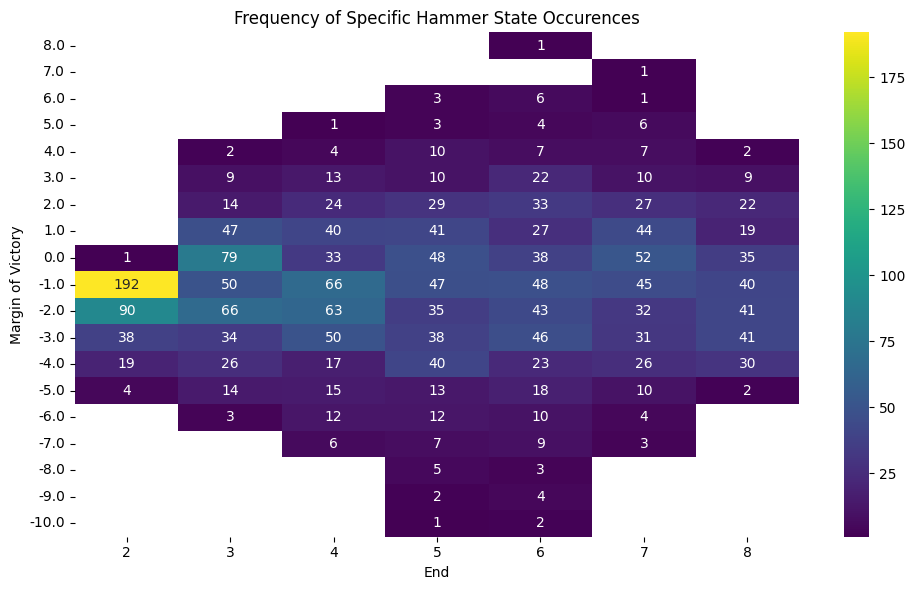

In [ ]:
# Frequency distribution of the Hammer team

freq_heatmap = (
    df[(df['Hammer'] == 1) & (df['EndID'].isin([2,3,4,5,6,7,8]))]
    .groupby(['EndID', 'SDLag'])
    .size()
    .reset_index(name='Frequency')
    .pivot(
        #index='EndID',
        #columns='SDLag',
        columns='EndID',
        index='SDLag',
        values='Frequency'
    )
)
freq_heatmap.sort_values(by='SDLag', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))

sns.heatmap(
    freq_heatmap,
    cmap='viridis',
    annot=True,
    fmt='.0f'
)

plt.xlabel('End')
plt.ylabel('Margin of Victory')
plt.title('Frequency of Specific Hammer State Occurences')

plt.tight_layout()
plt.show()


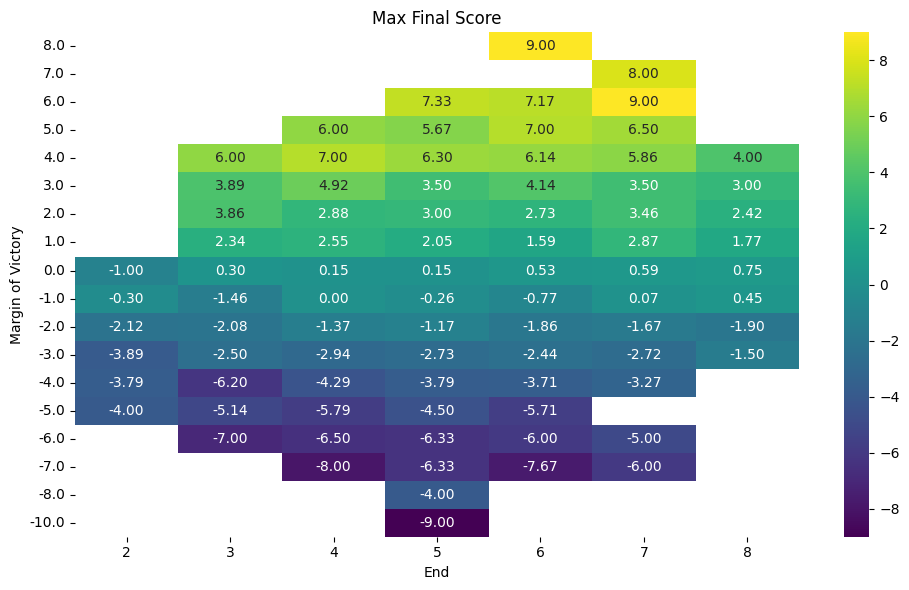

In [ ]:
# calculate quantiles or max/min/mean scores
heatmap = pd.pivot_table(
    win[(win['PP_Remain'] == 1) & (win['EndID'].isin(list(range(2,9))))],
    columns='EndID',
    index='SDLag',
    values='FinalScore',
    #aggfunc='max'
    #aggfunc='min'
    aggfunc='mean'
    #aggfunc = lambda x: x.quantile(0.75)
)
heatmap.sort_values(by='SDLag', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))

sns.heatmap(
    heatmap,
    cmap='viridis',
    annot=True,
    fmt='.2f'
)

plt.xlabel('End')
plt.ylabel('Margin of Victory')
plt.title('Max Final Score')

plt.tight_layout()
plt.show()


### **How likely is it for the Hammer Team to win by Game State?**

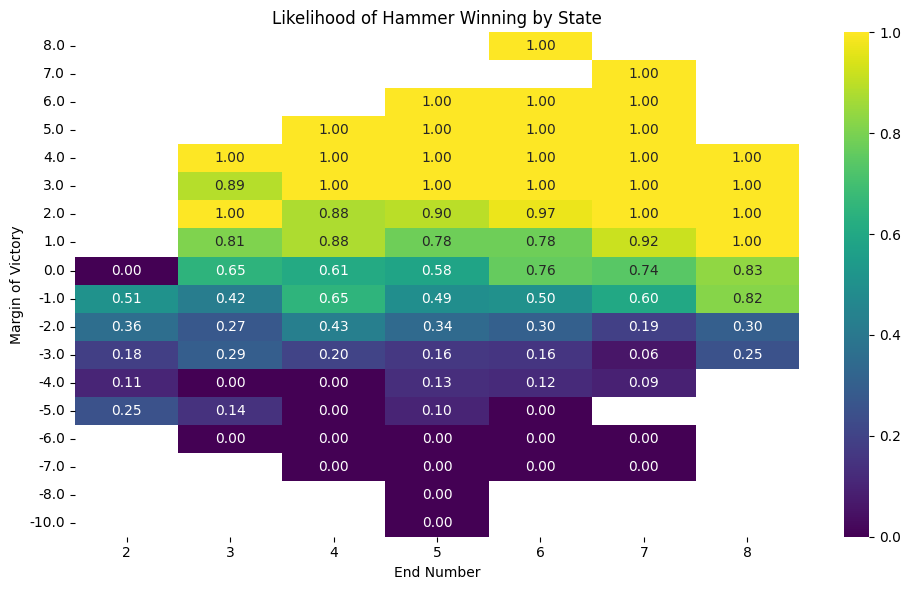

In [ ]:
heatmap = pd.pivot_table(
    win[(win['PP_Remain'] == 1) & (win['EndID'].isin(list(range(2,9))))],
    columns='EndID',
    index='SDLag',
    values='Win',
    aggfunc='mean'
)
heatmap.sort_values(by='SDLag', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))

sns.heatmap(
    heatmap,
    cmap='viridis',
    annot=True,
    fmt='.2f'
)

plt.xlabel('End Number')
plt.ylabel('Margin of Victory')
plt.title('Likelihood of Hammer Winning by State')

plt.tight_layout()
plt.show()


### **How likely is the Hammer Team to use the Powerplay based on current game state?**

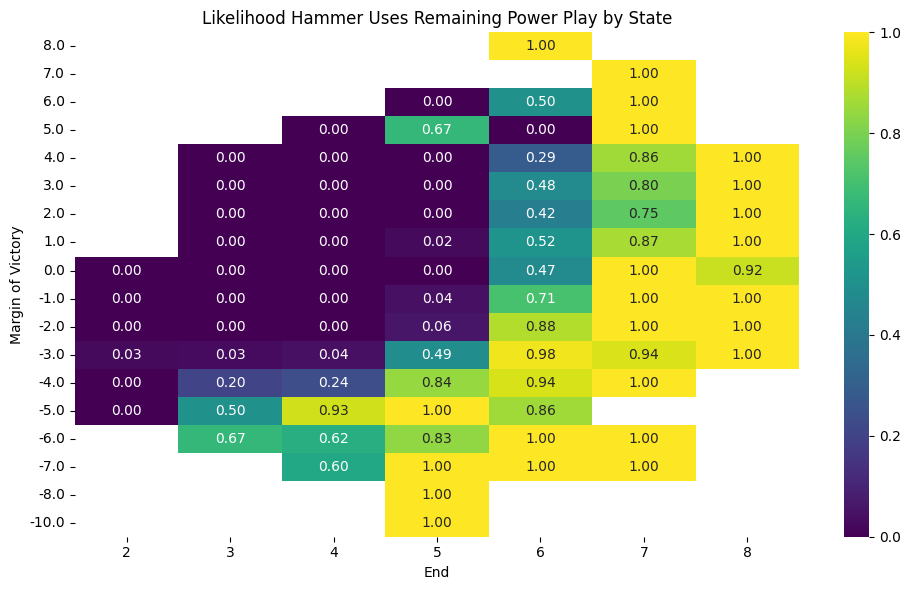

In [ ]:
heatmap = pd.pivot_table(
    df[(df['Hammer'] == 1) & (df['PP_Remain'] == 1) & (df['EndID'].isin(list(range(2,9))))],
    columns='EndID',
    index='SDLag',
    values='PP',
    aggfunc='mean'
)
heatmap.sort_values(by='SDLag', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))

sns.heatmap(
    heatmap,
    cmap='viridis',
    annot=True,
    fmt='.2f'
)

plt.xlabel('End')
plt.ylabel('Margin of Victory')
plt.title('Likelihood Hammer Uses Remaining Power Play by State')

plt.tight_layout()
plt.show()

When comparing these graphs, we see two different stories.  Close games and dominate wins have power plays in the last few ends.  Games where a team is losing and are likely to lose from early on, but still have a change to win, don't use the power play early.  Instead, they wait util defeat is certain, then use the power play.  Why is this?  They should benefit from using it earlier when there is still hope of a comeback.

### **State-by-State test: How does using a Power Play impact the odds of victory?**

There's a lot of limitations when trying to imagine data that doesn't exist, especially when the results of changes are likely to be relatively small.  This is far from a perfect test.  All models are wrong, but some are useful as the saying goes - and this will have some usability.

This attempts to evaluate increase (decrease) in odds of winning when a Power Play is used instead of foregone.

Pr(win | PP used last end) - Pr(win | PP remains)

Ideally, this will be the sum of possible points * odds of that point result happening given the state * Pr(win | PP was used or not), but as noted, the data to do this doesn't exist.  Instad of Pr(win | pp remains), for example, we have to compromise with Pr(win).  As well, we assumed the point distribution the hammer scores is independent of the state of the game, but that clearly has its shortcomings.

In [ ]:
# odds of winning when a power play remains
ppr_odds = pd.pivot_table(
    win[(win['PP_Remain'] == 1) & (win['EndID'].isin(list(range(2,9))))],
    columns='EndID',
    index='SDLag',
    values='Win',
    aggfunc='mean'
)
ppr_odds.sort_values(by='SDLag', ascending=False, inplace=True)

In [ ]:
# odds of winnning in general, both when power play remains and not
general_odds = pd.pivot_table(
    win[(win['EndID'].isin(list(range(3,9))))],
    columns='EndID',
    index='SDLag',
    values='Win',
    aggfunc='mean'
)
general_odds.sort_values(by='SDLag', ascending=False, inplace=True)

In [ ]:
# find point distributions without the PP and with the PP
regular_dist = df[(df['Hammer'] == 1) & (df['PP'] == 0)]['ScoreDifference'].value_counts().reset_index().sort_values(by='ScoreDifference', ascending=False)
regular_dist['odds'] = regular_dist['count'] / regular_dist['count'].sum()

pp_dist = df[df['PP'] == 1]['ScoreDifference'].value_counts().reset_index().sort_values(by='ScoreDifference', ascending=False)
pp_dist['odds'] = pp_dist['count'] / pp_dist['count'].sum()

In [ ]:
# make copy to transfer data over
matrix = ppr_odds.copy()

# perform analysis
for row_name in ppr_odds.index:
    for col_name in ppr_odds.columns:
        value = ppr_odds.loc[row_name, col_name]
        if pd.isna(value):
          matrix.loc[row_name, col_name] = pd.NA
        else:
          # get the expected win pct when the pp is used
          temp_pp = 0

          for _, i in pp_dist.iterrows():
            sd = i['ScoreDifference']
            odds = i['odds']
            # get the win pct from hammer's perspective depending on the next play
            if sd > 0:
                try:
                  win_pct = 1 - general_odds.loc[0 - (row_name + sd), col_name + 1]
                except:
                  win_pct = pd.NA
            else:
                try:
                  win_pct = general_odds.loc[row_name + sd, col_name + 1]
                except:
                  win_pct = pd.NA

            # if the value exists, add by the win_pct odds
            if not pd.isna(win_pct):
              temp_pp += odds * win_pct
            # if there isn't a value because of a blowout, just assume a dub
            elif row_name + sd > 3:
              temp_pp += odds

          # now less by the expected win pct if the pp isn't used
          temp_reg = 0
          for _, i in regular_dist.iterrows():
            sd = i['ScoreDifference']
            odds = i['odds']
            # get the win pct from hammer's perspective depending on the next play
            if sd > 0:
              try:
                win_pct = 1 - ppr_odds.loc[0 - (row_name + sd), col_name + 1]
              except:
                win_pct = pd.NA
            else:
              try:
                win_pct = ppr_odds.loc[row_name + sd, col_name + 1]
              except:
                win_pct = pd.NA

            # if the value exists, add multiplied by the win_pct odds
            if not pd.isna(win_pct):
              temp_reg += odds * win_pct
            elif row_name + sd > 3:
              temp_reg += odds

          try:
            if temp_reg > 0:
              delta = (temp_pp - temp_reg) * 100
            else:
              if temp_pp > 0:
                delta = temp_pp
              else:
                delta = 0
          except:
            delta = 0


          matrix.loc[row_name, col_name] = delta

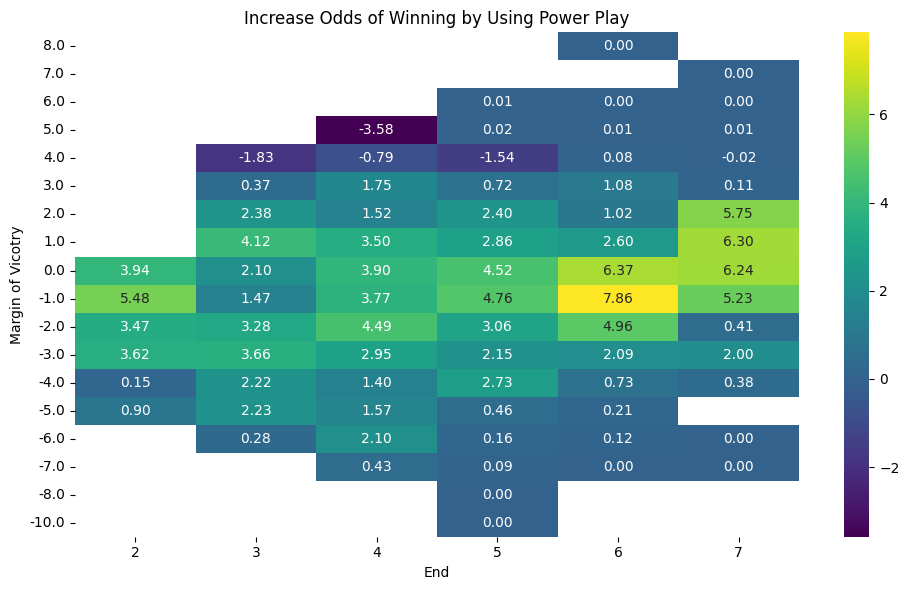

In [ ]:
early_matrix = matrix.loc[:, [2,3,4,5,6,7]]

plt.figure(figsize=(10, 6))

sns.heatmap(
    early_matrix,
    cmap='viridis',
    annot=True,
    fmt='.2f'
)

plt.xlabel('End')
plt.ylabel('Margin of Vicotry')
plt.title('Increase Odds of Winning by Using Power Play')

plt.tight_layout()
plt.show()

***Figure 7**: Increase in odds of winning by using the power play in a given state*

When looking at MOVs < -2, we see that using the PP earlier generally resulted in larger increases in odds of winning, suggesting that getting yourself back in the fight early can better your odds of redemption.  For closer games though, there may be more appeal to reserve the PP for later ends.

More data needs to be collected on attempts to use the power play earlier in the game, possibly from practices or lower-level competitions where the stakes of trying new things are lower.  This will give additional insight to how likely a team is to win given they don’t have a PP remaining and allow for clearer recommendations on when the optimal time to use the PP is.  What we can say with high confidence now is that teams are waiting too long to use the PP when they fall behind.  We also strongly recommend for teams to consider using the PP as early as the 3rd end when they find themselves with a MOV of -3 or lower.

Losing teams need to use the power play sooner than they think, before they fall too far behind to catch up.
